In [1]:
#v1
#26/10/2018

dataname="melanoma_png_8"
#pytable_root = '/mnt/ccipd_home/yxz1826/Skin/pytable'
pytable_root = "C:\\pytable"

ignore_index = 0    #Unet has the possibility of masking out pixels in the output image, we can specify the index value here (though not used)
gpuid=0

# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes= 4    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 3       #depth of the network 
wf= 4           #wf (int): number of filters in the first layer is 2**wf
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size=10
patch_size=256
num_epochs = 100
edge_weight = 1.1 #edges tend to be the most poorly segmented given how little area they occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

import scipy.ndimage

from tensorboardX import SummaryWriter

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

In [3]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce GTX 1080 Ti', major=6, minor=1, total_memory=11264MB, multi_processor_count=28)


In [5]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	117732


In [6]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None, mask_transform = None, edge_weight= False):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        self.edge_weight = edge_weight
        
        self.img_transform=img_transform
        self.mask_transform = mask_transform
        
        self.tables=tables.open_file(self.fname)
        self.numpixels=self.tables.root.numpixels[:]
        #print(self.fname)
        self.nitems=self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here
        if(self.img is None): #open in thread
            self.tables=tables.open_file(self.fname)
            self.img=self.tables.root.img
            self.mask=self.tables.root.mask
       
        #get the requested image and mask from the pytable
        img = self.img[index,:,:,:]
        mask = self.mask[index,:,:]
        
        #the original Unet paper assignes increased weights to the edges of the annotated objects
        #their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        #highlight all the pixels which were "added"
        if(self.edge_weight):
            weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~mask
        else: #otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        mask = mask[:,:,None].repeat(3,axis=2) #in order to use the transformations given by torchvision
        weight = weight[:,:,None].repeat(3,axis=2) #inputs need to be 3D, so here we convert from 1d to 3d by repetition
        
        img_new = img
        mask_new = mask
        weight_new = weight
        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transofrmations
        if self.img_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            random.seed(seed)
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0].squeeze()
            
            random.seed(seed)
            weight_new = self.mask_transform(weight)
            weight_new = np.asarray(weight_new)[:,:,0].squeeze()

        return img_new, mask_new, weight_new
    def __len__(self):
        return self.nitems

In [7]:
#note that since we need the transofrmations to be reproducible for both masks and images
#we do the spatial transformations first, and afterwards do any color augmentations
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
    transforms.RandomRotation(180),
    ])



In [8]:



dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    print(phase)
    dataset[phase]=Dataset(f"{pytable_root}/{dataname}_{phase}.pytable", img_transform=img_transform , mask_transform = mask_transform ,edge_weight=edge_weight)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) 
print(len(dataset["train"]))

train
val
44205


0


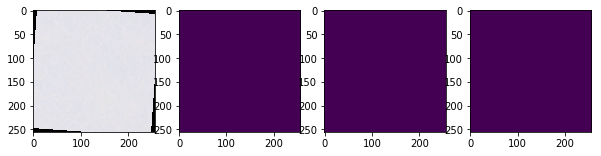

In [9]:
#visualize a single example to verify that it is correct
(img,patch_mask,patch_mask_weight)=dataset["train"][12395]
fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns
print(patch_mask.max())
#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask==3)
ax[2].imshow(patch_mask_weight)
ax[3].imshow(patch_mask)

In [10]:
optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust, though perhaps not the best performing, typically a good place to start
# optim = torch.optim.SGD(model.parameters(),
#                           lr=.1,
#                           momentum=0.9,
#                           weight_decay=0.0005)

In [11]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class
nclasses = dataset["train"].numpixels.shape[1]
#0 is ignored
class_weight=dataset["train"].numpixels[1,1:nclasses] #don't take ignored class into account here
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(ignore_index = ignore_index ,reduce=None) #reduce = False makes sure we get a 2D output instead of a 1D "summary" value
print("numclass",nclasses)
print("ignore",ignore_index)
print()

tensor([0.7752, 0.8769, 0.3479], device='cuda:0')
numclass 4
ignore 0



In [12]:
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity
cmatList = []
start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: np.zeros(None) for key in phases}
    cmatrix = {key: np.zeros((nclasses,nclasses)) for key in phases}
    
    for phase in phases: #iterate through both training and validation states
                    
        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, y, y_weight) in tqdm(enumerate(dataLoader[phase])): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)
            
            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass, H, W]
                #print(type(criterion(prediction, y)))
                loss_matrix = criterion(prediction, y)
                
                loss = (loss_matrix * (edge_weight**y_weight).type('torch.cuda.FloatTensor')).mean() #debug.mean() #can skip if edge weight==1
                torch.cuda.synchronize()
                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss

                    
                all_loss[phase] = np.append(all_loss[phase], loss.detach().cpu().numpy()) #always add loss

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction[:,:,:,:].squeeze().detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=y.cpu().numpy().flatten()
                    #check:ValueError: operands could not be broadcast together with shapes (4,4) (3,3) 
                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat,dataset["train"].numpixels[0][0:nclasses])
                    #print(yflat)
        cmatList.append(cmatrix)
        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            #0 1 2 3 -->1 n 3n 2P
            TN = cmatrix[phase][0+1,0+1]+cmatrix[phase][2+1,2+1]
            TP = cmatrix[phase][1+1,1+1]
            FP = cmatrix[phase][0+1,1+1] +  cmatrix[phase][2+1,1+1]
            FN = cmatrix[phase][1+1,0+1] + cmatrix[phase][1+1,2+1]
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            writer.add_scalar(f'{phase}/TN',TN , epoch)
            writer.add_scalar(f'{phase}/TP', TP, epoch)
            writer.add_scalar(f'{phase}/FP', FP, epoch)
            writer.add_scalar(f'{phase}/FN', FN, epoch)
            writer.add_scalar(f'{phase}/TNR', TN/(TN+FN), epoch)
            writer.add_scalar(f'{phase}/TPR', TP/(TP+FP), epoch)
                
    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'n_classes': n_classes,
         'in_channels': in_channels,
         'padding': padding,
         'depth': depth,
         'wf': wf,
         'up_mode': up_mode, 'batch_norm': batch_norm}

        
        torch.save(state, f"{dataname}_unet_best_model.pth")
    else:
        print("")
        

4421it [17:50,  4.61it/s]
c:\program files\python\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
420it [03:58,  1.99it/s]
c:\program files\python\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


21m 49s (- 2158m 27s) ([1/100] 1%), train loss: 0.8639 test loss: 0.9415  **


4421it [18:10,  4.75it/s]
420it [03:58,  2.00it/s]


43m 58s (- 2153m 59s) ([2/100] 2%), train loss: 0.8383 test loss: 0.9270  **


4421it [17:46,  4.87it/s]
420it [03:49,  2.04it/s]


65m 34s (- 2119m 41s) ([3/100] 3%), train loss: 0.8293 test loss: 0.9034  **


4421it [17:36,  4.85it/s]
420it [03:53,  2.09it/s]


87m 4s (- 2089m 18s) ([4/100] 4%), train loss: 0.8275 test loss: 0.8907  **


4421it [18:06,  4.73it/s]
420it [03:56,  2.04it/s]


109m 8s (- 2073m 10s) ([5/100] 5%), train loss: 0.8214 test loss: 0.9125


4421it [18:03,  4.72it/s]
420it [03:54,  2.02it/s]


131m 6s (- 2053m 37s) ([6/100] 6%), train loss: 0.8160 test loss: 0.9111


4421it [18:01,  4.87it/s]
420it [03:53,  1.90it/s]


153m 1s (- 2032m 48s) ([7/100] 7%), train loss: 0.8062 test loss: 0.8842  **


4421it [18:15,  4.42it/s]
420it [04:00,  1.95it/s]


175m 17s (- 2015m 39s) ([8/100] 8%), train loss: 0.7995 test loss: 0.8813  **


4421it [18:54,  4.55it/s]
420it [03:59,  2.05it/s]


198m 12s (- 2003m 48s) ([9/100] 9%), train loss: 0.7891 test loss: 0.9077


4421it [18:01,  4.84it/s]
420it [03:54,  2.05it/s]


220m 7s (- 1980m 58s) ([10/100] 10%), train loss: 0.7871 test loss: 0.8644  **


4421it [18:04,  4.79it/s]
420it [03:54,  2.04it/s]


242m 6s (- 1958m 42s) ([11/100] 11%), train loss: 0.7779 test loss: 0.9418


4421it [17:55,  4.80it/s]
420it [03:53,  2.04it/s]


263m 56s (- 1935m 20s) ([12/100] 12%), train loss: 0.7782 test loss: 0.8926


4421it [17:57,  4.73it/s]
420it [03:53,  2.03it/s]


285m 47s (- 1912m 24s) ([13/100] 13%), train loss: 0.7766 test loss: 0.8654


4421it [17:57,  4.68it/s]
420it [03:53,  2.01it/s]


307m 37s (- 1889m 35s) ([14/100] 14%), train loss: 0.7726 test loss: 0.8998


4421it [17:58,  4.77it/s]
420it [03:53,  2.01it/s]


329m 30s (- 1867m 2s) ([15/100] 15%), train loss: 0.7706 test loss: 0.8797


4421it [17:44,  4.91it/s]
420it [03:49,  2.08it/s]


351m 3s (- 1842m 55s) ([16/100] 16%), train loss: 0.7679 test loss: 0.8734


4421it [17:37,  4.83it/s]
420it [03:48,  2.07it/s]


372m 29s (- 1818m 28s) ([17/100] 17%), train loss: 0.7701 test loss: 0.8541  **


4421it [17:29,  4.94it/s]
420it [03:48,  2.08it/s]


393m 46s (- 1793m 44s) ([18/100] 18%), train loss: 0.7621 test loss: 0.8780


4421it [17:34,  4.71it/s]
420it [04:07,  1.37it/s]


415m 28s (- 1771m 7s) ([19/100] 19%), train loss: 0.7696 test loss: 0.8770


4421it [18:28,  4.87it/s]
420it [03:50,  2.03it/s]


437m 47s (- 1751m 3s) ([20/100] 20%), train loss: 0.7618 test loss: 0.8707


4421it [17:41,  4.57it/s]
420it [03:53,  2.00it/s]


459m 22s (- 1728m 1s) ([21/100] 21%), train loss: 0.7661 test loss: 0.8531  **


4421it [17:34,  4.88it/s]
420it [03:51,  2.08it/s]


480m 48s (- 1704m 34s) ([22/100] 22%), train loss: 0.7549 test loss: 0.8823


4421it [17:26,  4.91it/s]
420it [03:48,  2.07it/s]


502m 3s (- 1680m 41s) ([23/100] 23%), train loss: 0.7575 test loss: 0.8853


4421it [18:00,  4.59it/s]
420it [03:51,  2.05it/s]


523m 55s (- 1659m 1s) ([24/100] 24%), train loss: 0.7561 test loss: 0.8799


4421it [17:38,  4.75it/s]
420it [03:49,  2.06it/s]


545m 23s (- 1636m 6s) ([25/100] 25%), train loss: 0.7589 test loss: 0.8448  **


4421it [17:44,  4.80it/s]
420it [03:55,  2.01it/s]


567m 4s (- 1613m 52s) ([26/100] 26%), train loss: 0.7558 test loss: 0.8560


4421it [17:24,  4.91it/s]
420it [03:45,  2.10it/s]


588m 14s (- 1590m 20s) ([27/100] 27%), train loss: 0.7522 test loss: 0.8807


4421it [17:24,  4.87it/s]
420it [03:46,  2.10it/s]


609m 24s (- 1566m 59s) ([28/100] 28%), train loss: 0.7499 test loss: 0.8619


4421it [17:21,  4.99it/s]
420it [03:46,  2.12it/s]


630m 33s (- 1543m 41s) ([29/100] 28%), train loss: 0.7485 test loss: 0.8520


4421it [17:11,  4.91it/s]
420it [03:43,  2.16it/s]


651m 28s (- 1520m 2s) ([30/100] 30%), train loss: 0.7450 test loss: 0.8558


4421it [17:38,  4.79it/s]
420it [03:54,  2.01it/s]


673m 1s (- 1497m 58s) ([31/100] 31%), train loss: 0.7502 test loss: 0.8437  **


4421it [17:45,  4.96it/s]
420it [03:49,  2.06it/s]


694m 37s (- 1475m 59s) ([32/100] 32%), train loss: 0.7474 test loss: 0.8812


4421it [17:32,  4.82it/s]
420it [03:49,  2.06it/s]


715m 59s (- 1453m 36s) ([33/100] 33%), train loss: 0.7456 test loss: 0.8792


4421it [17:34,  4.89it/s]
420it [03:52,  2.06it/s]


737m 26s (- 1431m 26s) ([34/100] 34%), train loss: 0.7476 test loss: 0.8721


4421it [17:49,  4.79it/s]
420it [03:54,  2.03it/s]


759m 10s (- 1409m 49s) ([35/100] 35%), train loss: 0.7418 test loss: 0.8628


4421it [17:38,  4.92it/s]
420it [03:44,  2.10it/s]


780m 33s (- 1387m 36s) ([36/100] 36%), train loss: 0.7452 test loss: 0.8777


4421it [17:13,  4.89it/s]
420it [03:48,  2.12it/s]


801m 35s (- 1364m 49s) ([37/100] 37%), train loss: 0.7374 test loss: 0.8497


4421it [17:14,  5.02it/s]
420it [03:44,  2.12it/s]


822m 34s (- 1342m 3s) ([38/100] 38%), train loss: 0.7401 test loss: 0.8427  **


4421it [17:14,  5.00it/s]
420it [03:45,  2.06it/s]


843m 34s (- 1319m 23s) ([39/100] 39%), train loss: 0.7447 test loss: 0.8352  **


4421it [17:16,  4.91it/s]
420it [03:45,  2.09it/s]


864m 36s (- 1296m 51s) ([40/100] 40%), train loss: 0.7423 test loss: 0.8955


4421it [17:13,  5.02it/s]
420it [03:44,  2.11it/s]


885m 35s (- 1274m 19s) ([41/100] 41%), train loss: 0.7427 test loss: 0.8302  **


4421it [17:14,  4.94it/s]
420it [03:45,  2.14it/s]


906m 34s (- 1251m 53s) ([42/100] 42%), train loss: 0.7403 test loss: 0.8593


4421it [17:14,  5.00it/s]
420it [03:44,  2.10it/s]


927m 33s (- 1229m 30s) ([43/100] 43%), train loss: 0.7401 test loss: 0.8696


4421it [17:15,  4.94it/s]
420it [03:44,  2.12it/s]


948m 33s (- 1207m 12s) ([44/100] 44%), train loss: 0.7332 test loss: 0.8406


4421it [17:14,  4.73it/s]
420it [03:45,  2.11it/s]


969m 33s (- 1184m 57s) ([45/100] 45%), train loss: 0.7396 test loss: 0.9086


4421it [17:14,  4.84it/s]
420it [03:44,  2.10it/s]


990m 32s (- 1162m 45s) ([46/100] 46%), train loss: 0.7435 test loss: 0.8861


4421it [17:14,  5.06it/s]
420it [03:44,  2.13it/s]


1011m 32s (- 1140m 37s) ([47/100] 47%), train loss: 0.7392 test loss: 0.8572


4421it [17:14,  5.04it/s]
420it [03:44,  2.09it/s]


1032m 31s (- 1118m 31s) ([48/100] 48%), train loss: 0.7386 test loss: 0.8582


4421it [17:14,  4.83it/s]
420it [03:44,  2.12it/s]


1053m 31s (- 1096m 29s) ([49/100] 49%), train loss: 0.7387 test loss: 0.8587


4421it [17:13,  5.05it/s]
420it [03:45,  2.11it/s]


1074m 30s (- 1074m 27s) ([50/100] 50%), train loss: 0.7347 test loss: 0.8839


4421it [17:13,  4.93it/s]
420it [03:44,  2.12it/s]


1095m 29s (- 1052m 28s) ([51/100] 51%), train loss: 0.7344 test loss: 0.8468


4421it [17:26,  4.93it/s]
420it [03:44,  2.10it/s]


1116m 40s (- 1030m 44s) ([52/100] 52%), train loss: 0.7392 test loss: 0.8568


4421it [17:19,  4.81it/s]
420it [03:44,  2.06it/s]


1137m 44s (- 1008m 54s) ([53/100] 53%), train loss: 0.7308 test loss: 0.8389


4421it [17:20,  5.00it/s]
420it [03:44,  2.08it/s]


1158m 49s (- 987m 6s) ([54/100] 54%), train loss: 0.7369 test loss: 0.8774


4421it [17:21,  4.91it/s]
420it [03:44,  2.14it/s]


1179m 55s (- 965m 21s) ([55/100] 55%), train loss: 0.7369 test loss: 0.8303


4421it [17:20,  4.98it/s]
420it [03:44,  2.13it/s]


1201m 0s (- 943m 36s) ([56/100] 56%), train loss: 0.7287 test loss: 0.8460


4421it [17:23,  4.83it/s]
420it [03:44,  2.10it/s]


1222m 8s (- 921m 56s) ([57/100] 56%), train loss: 0.7327 test loss: 0.8737


4421it [17:23,  4.91it/s]
420it [03:44,  2.11it/s]


1243m 17s (- 900m 16s) ([58/100] 57%), train loss: 0.7291 test loss: 0.8646


4421it [17:22,  4.90it/s]
420it [03:44,  2.09it/s]


1264m 24s (- 878m 37s) ([59/100] 59%), train loss: 0.7280 test loss: 0.8437


4421it [17:19,  4.82it/s]
420it [03:44,  2.11it/s]


1285m 28s (- 856m 57s) ([60/100] 60%), train loss: 0.7310 test loss: 0.8823


4421it [17:20,  5.03it/s]
420it [03:44,  2.10it/s]


1306m 33s (- 835m 18s) ([61/100] 61%), train loss: 0.7320 test loss: 0.8703


4421it [17:21,  4.91it/s]
420it [03:44,  2.10it/s]


1327m 40s (- 813m 41s) ([62/100] 62%), train loss: 0.7307 test loss: 0.8704


4421it [17:21,  4.86it/s]
420it [03:45,  2.10it/s]


1348m 46s (- 792m 6s) ([63/100] 63%), train loss: 0.7280 test loss: 0.8752


4421it [17:19,  4.87it/s]
420it [03:44,  2.07it/s]


1369m 50s (- 770m 30s) ([64/100] 64%), train loss: 0.7294 test loss: 0.8630


4421it [17:24,  4.88it/s]
420it [03:44,  2.13it/s]


1390m 59s (- 748m 57s) ([65/100] 65%), train loss: 0.7288 test loss: 0.8519


4421it [17:20,  4.88it/s]
420it [03:45,  2.14it/s]


1412m 4s (- 727m 24s) ([66/100] 66%), train loss: 0.7304 test loss: 0.8620


4421it [17:21,  4.97it/s]
420it [03:45,  2.10it/s]


1433m 12s (- 705m 52s) ([67/100] 67%), train loss: 0.7266 test loss: 0.8532


4421it [17:16,  4.88it/s]
420it [03:43,  2.10it/s]


1454m 12s (- 684m 18s) ([68/100] 68%), train loss: 0.7205 test loss: 0.8602


4421it [17:16,  4.95it/s]
420it [03:44,  2.12it/s]


1475m 13s (- 662m 44s) ([69/100] 69%), train loss: 0.7218 test loss: 0.8776


4421it [17:20,  5.08it/s]
420it [03:43,  2.11it/s]


1496m 17s (- 641m 14s) ([70/100] 70%), train loss: 0.7257 test loss: 0.8775


4421it [17:18,  4.88it/s]
420it [03:44,  2.13it/s]


1517m 21s (- 619m 43s) ([71/100] 71%), train loss: 0.7245 test loss: 0.8528


4421it [17:18,  4.90it/s]
420it [03:44,  2.14it/s]


1538m 23s (- 598m 14s) ([72/100] 72%), train loss: 0.7269 test loss: 0.8677


4421it [17:15,  4.95it/s]
420it [03:46,  2.12it/s]


1559m 26s (- 576m 44s) ([73/100] 73%), train loss: 0.7209 test loss: 0.9067


4421it [17:20,  4.91it/s]
420it [03:44,  2.09it/s]


1580m 31s (- 555m 17s) ([74/100] 74%), train loss: 0.7212 test loss: 0.8513


4421it [17:20,  4.93it/s]
420it [03:44,  2.13it/s]


1601m 36s (- 533m 50s) ([75/100] 75%), train loss: 0.7288 test loss: 0.8809


4421it [17:20,  4.90it/s]
420it [03:50,  2.15it/s]


1622m 46s (- 512m 25s) ([76/100] 76%), train loss: 0.7203 test loss: 0.8479


4421it [17:17,  4.93it/s]
420it [03:44,  2.10it/s]


1643m 49s (- 490m 58s) ([77/100] 77%), train loss: 0.7279 test loss: 0.8563


4421it [17:19,  4.80it/s]
420it [03:49,  2.08it/s]


1664m 57s (- 469m 34s) ([78/100] 78%), train loss: 0.7208 test loss: 0.8658


4421it [17:32,  4.89it/s]
420it [03:48,  2.07it/s]


1686m 19s (- 448m 14s) ([79/100] 79%), train loss: 0.7229 test loss: 0.8381


4421it [17:32,  4.86it/s]
420it [03:49,  2.04it/s]


1707m 41s (- 426m 53s) ([80/100] 80%), train loss: 0.7223 test loss: 0.8509


4421it [17:32,  4.94it/s]
420it [03:50,  2.00it/s]


1729m 4s (- 405m 33s) ([81/100] 81%), train loss: 0.7134 test loss: 0.8639


4421it [17:35,  4.86it/s]
420it [03:50,  2.07it/s]


1750m 30s (- 384m 14s) ([82/100] 82%), train loss: 0.7219 test loss: 0.8849


4421it [17:36,  4.93it/s]
420it [03:49,  2.09it/s]


1771m 57s (- 362m 54s) ([83/100] 83%), train loss: 0.7190 test loss: 0.8645


4421it [17:36,  4.90it/s]
420it [03:51,  2.08it/s]


1793m 24s (- 341m 34s) ([84/100] 84%), train loss: 0.7216 test loss: 0.8384


4421it [17:40,  4.82it/s]
420it [03:51,  2.07it/s]


1814m 56s (- 320m 15s) ([85/100] 85%), train loss: 0.7155 test loss: 0.8528


4421it [17:38,  4.89it/s]
420it [03:50,  2.06it/s]


1836m 24s (- 298m 55s) ([86/100] 86%), train loss: 0.7207 test loss: 0.8573


4421it [17:35,  4.92it/s]
420it [03:50,  2.07it/s]


1857m 51s (- 277m 35s) ([87/100] 87%), train loss: 0.7128 test loss: 0.8416


4421it [17:37,  4.85it/s]
420it [03:50,  2.07it/s]


1879m 19s (- 256m 14s) ([88/100] 88%), train loss: 0.7173 test loss: 0.8493


4421it [17:36,  4.84it/s]
420it [03:50,  2.03it/s]


1900m 46s (- 234m 54s) ([89/100] 89%), train loss: 0.7145 test loss: 0.8528


4421it [17:35,  4.92it/s]
420it [03:50,  2.07it/s]


1922m 11s (- 213m 33s) ([90/100] 90%), train loss: 0.7214 test loss: 0.8479


4421it [17:38,  4.89it/s]
420it [03:48,  2.06it/s]


1943m 39s (- 192m 12s) ([91/100] 91%), train loss: 0.7181 test loss: 0.8645


4421it [17:29,  4.92it/s]
420it [03:44,  2.11it/s]


1964m 53s (- 170m 50s) ([92/100] 92%), train loss: 0.7173 test loss: 0.8575


4421it [17:19,  4.78it/s]
420it [03:45,  2.11it/s]


1985m 58s (- 149m 27s) ([93/100] 93%), train loss: 0.7157 test loss: 0.8605


4421it [17:20,  4.85it/s]
420it [03:45,  2.10it/s]


2007m 3s (- 128m 5s) ([94/100] 94%), train loss: 0.7163 test loss: 0.8541


4421it [17:19,  4.95it/s]
420it [03:45,  2.13it/s]


2028m 8s (- 106m 43s) ([95/100] 95%), train loss: 0.7122 test loss: 0.8432


4421it [17:21,  4.86it/s]
420it [03:44,  2.09it/s]


2049m 15s (- 85m 21s) ([96/100] 96%), train loss: 0.7172 test loss: 0.8650


4421it [17:22,  4.96it/s]
420it [03:44,  2.08it/s]


2070m 23s (- 64m 0s) ([97/100] 97%), train loss: 0.7164 test loss: 0.8405


4421it [17:22,  4.91it/s]
420it [03:45,  2.12it/s]


2091m 30s (- 42m 39s) ([98/100] 98%), train loss: 0.7123 test loss: 0.8664


4421it [17:22,  4.91it/s]
420it [03:45,  2.11it/s]


2112m 38s (- 21m 19s) ([99/100] 99%), train loss: 0.7118 test loss: 0.8567


4421it [17:20,  4.87it/s]
420it [03:45,  2.11it/s]


2133m 44s (- -1m 58s) ([100/100] 100%), train loss: 0.7112 test loss: 0.8424


In [16]:

np.unique(yflat)


array([0], dtype=int64)

In [15]:
#----- generate output
#load best model
checkpoint = torch.load(f"{dataname}_unet_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

In [16]:
#grab a single image from validation set
[img,mask,mask_weight]=dataset["val"][2]

In [17]:
#generate its output
#%%timeit
output=model(img[None,::].to(device))
output=output.detach().squeeze().cpu().numpy()
output=np.moveaxis(output,0,-1) 
output.shape

(256, 256, 4)

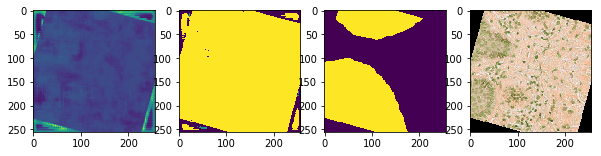

In [18]:
#visualize its result
fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns

ax[0].imshow(output[:,:,1])
ax[1].imshow(np.argmax(output,axis=2))
ax[2].imshow(mask)
ax[3].imshow(np.moveaxis(img.numpy(),0,-1))


In [ ]:
#------- visualize kernels and activations

In [19]:
#helper function for visualization
def plot_kernels(tensor, num_cols=8 ,cmap="gray"):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
#    if not tensor.shape[1]==3:
#        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0] * tensor.shape[1]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    i=0
    t=tensor.data.numpy()
    for t1 in t:
        for t2 in t1:
            i+=1
            ax1 = fig.add_subplot(num_rows,num_cols,i)
            ax1.imshow(t2 , cmap=cmap)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [20]:
class LayerActivations():
    features=None
    def __init__(self,layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    def remove(self):
        self.hook.remove()

In [21]:
# --- visualize kernels

In [22]:
w=model.up_path[2].conv_block.block[3]
plot_kernels(w.weight.detach().cpu(),8)

IndexError: index 2 is out of range

In [ ]:
# ---- visualize activiations

In [23]:
dr=LayerActivations(model.up_path[2].conv_block.block[3])

IndexError: index 2 is out of range

NameError: name 'dr' is not defined

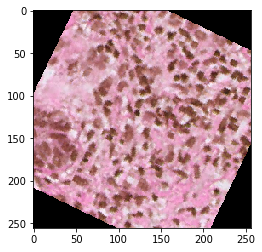

In [24]:
[img,mask,mask_weight]=dataset["val"][7]
plt.imshow(np.moveaxis(img.numpy(),0,-1))
output=model(img[None,::].to(device))
plot_kernels(dr.features,8,cmap="rainbow")

In [27]:
TN = cmatrix[phase][0+1,0+1]+cmatrix[phase][2+1,2+1]
TP = cmatrix[phase][1+1,1+1]
FP = cmatrix[phase][0+1,1+1] +  cmatrix[phase][2+1,1+1]
FN = cmatrix[phase][1+1,0+1] + cmatrix[phase][1+1,2+1]

In [31]:
print('TNR', TN/(TN+FN))
print('FNR', FN/(TN+FN))
print('TPR', TP/(TP+FP))
print('FPR', FP/(TP+FP))
print('ACC', (TN+TP)/(FN+TN+TP+FP))

TNR 0.7690183165749803
FNR 0.23098168342501965
TPR 0.6687119582788625
FPR 0.3312880417211375
ACC 0.7688431237469392


In [32]:
## ---- Improvements:
#1 replace Adam with SGD with appropriate learning rate reduction
 #0 1 2 3 -->1 n 3-drop 2P
TN2 = cmatrix[phase][0+1,0+1]
TP2 = cmatrix[phase][1+1,1+1]
FP2 = cmatrix[phase][0+1,1+1]
FN2 = cmatrix[phase][1+1,0+1]

In [33]:
print('TNR', TN2/(TN2+FN2))
print('FNR', FN2/(TN2+FN2))
print('TPR', TP2/(TP2+FP2))
print('FPR', FP2/(TP2+FP2))
print('ACC', (TN2+TP2)/(FN2+TN2+TP2+FP2))

TNR 0.857546803020842
FNR 0.14245319697915806
TPR 0.9303210161436994
FPR 0.06967898385630054
ACC 0.8973154649311232
